### Visualizing the distribution of the observations

### Load the required libraries

In [5]:
sc.stop()

In [4]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init("C:\opt\spark")

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBBBSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12673
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    40|[90 D5 00 7E 00 7...|1894.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    43|[A0 D6 A0 D6 00 7...|1895.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    22|[A0 D3 00 C6 00 0...|1898.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    47|[00 7E E0 D5 A0 D...|1900.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    47|[00 7E 00 7E 00 7...|1901.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+-------------

In [5]:
m = 'SNWD'

In [6]:
STAT[m]['eigvec'].shape

(365L, 365L)

### Select data for a particular station and measurement type

In [7]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMIN','USC00326025')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMIN' and station='USC00326025'
81 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    500.2| 48.7603|-101.5089|       TMIN|USC00326025|    34|[B0 D8 00 7E 00 7...|1894.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       TMIN|USC00326025|    42|[10 DA 00 7E 00 7...|1895.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(81L, 365L)

In [8]:
Query_Year = "SELECT year FROM weather"
year_list = sqlContext.sql(Query_Year).collect()
years = [row[0] for row in year_list]
print min(years),max(years)

1884.0 2012.0


# Original Implementation of Study of Rise in Winter Temperatures

In [9]:
def return_temp_data(measurement):

    Query_temp = "SELECT * FROM weather\n\tWHERE measurement= '"+measurement+"' and station='%s'"%('USC00326025')
    print Query_temp
    df_T = sqlContext.sql(Query_temp)
    print df_T.count(),'rows'
    df_T.show(2)
    rows=df_T.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
    T_max = np.vstack(rows)
    return T_max

In [ ]:
from scipy import stats

In [62]:
def plot_winter(T,measurement):
    winter_temp = []
    for temp in T:
        winter_temp.append(np.nanmean(temp))
    xi = np.arange(0,len(winter_temp))
    slope, intercept, r_value, p_value, std_err = stats.linregress(xi,winter_temp)
    line = slope*xi+intercept
    print "slope is :"+str(slope)
    plt.plot(xi,winter_temp,'o', xi, line)
    plt.title("Mean "+measurement+" statistics for past "+str(len(xi))+" years")
    plt.ylabel(measurement)
    plt.xlabel("years")
    #plt.plot(winter_temp,'rx')

In [67]:
def plot_winter_var(T,measurement):
    winter_temp = []
    for temp in T:
        winter_temp.append(np.nanstd(temp))
    print winter_temp
    xi = np.arange(0,len(winter_temp))
    slope, intercept, r_value, p_value, std_err = stats.linregress(xi,winter_temp)
    line = slope*xi+intercept
    print "slope is :"+str(slope)
    plt.plot(xi,winter_temp,'o', xi, line)
    plt.title("Std Deviation "+measurement+" statistics for past "+str(len(xi))+" years")
    plt.ylabel(measurement)
    plt.xlabel("years")

SELECT * FROM weather
	WHERE measurement= 'TMIN' and station='USC00326025'
81 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    500.2| 48.7603|-101.5089|       TMIN|USC00326025|    34|[B0 D8 00 7E 00 7...|1894.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       TMIN|USC00326025|    42|[10 DA 00 7E 00 7...|1895.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

slope is :0.128699711883


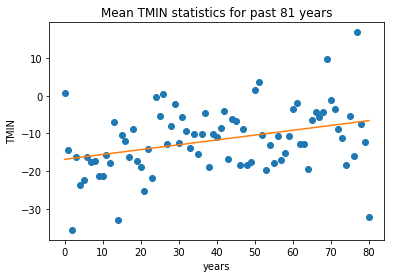

In [64]:
T_min = return_temp_data('TMIN')
plot_winter(T_min,'TMIN')

SELECT * FROM weather
	WHERE measurement= 'TMAX' and station='USC00326025'
68 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    40|[90 D5 00 7E 00 7...|1894.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    43|[A0 D6 A0 D6 00 7...|1895.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

slope is :-0.0644503664542


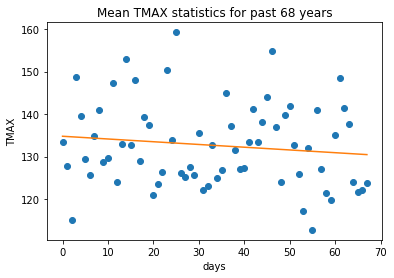

In [32]:
T_min = return_temp_data('TMAX')
plot_winter(T_min,'TMAX')

SELECT * FROM weather
	WHERE measurement= 'SNWD' and station='USC00326025'
38 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    500.2| 48.7603|-101.5089|       SNWD|USC00326025|    49|[90 59 90 59 5C 5...|1951.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       SNWD|USC00326025|    45|[F0 57 F0 57 F0 5...|1952.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

slope is :0.138406229484


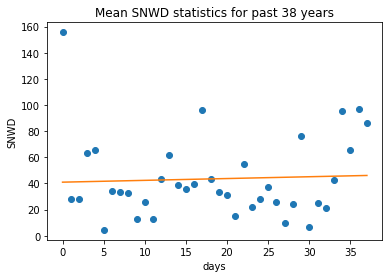

In [33]:
T_min = return_temp_data('SNWD')
plot_winter(T_min,'SNWD')

SELECT * FROM weather
	WHERE measurement= 'SNOW' and station='USC00326025'
51 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    500.2| 48.7603|-101.5089|       SNOW|USC00326025|     8|[00 00 00 00 00 0...|1949.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       SNOW|USC00326025|     3|[00 00 00 48 00 0...|1950.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

slope is :0.00453465250283


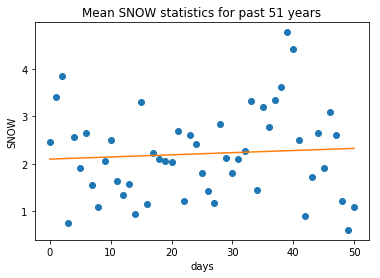

In [34]:
T_min = return_temp_data('SNOW')
plot_winter(T_min,'SNOW')

SELECT * FROM weather
	WHERE measurement= 'PRCP' and station='USC00326025'
94 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    500.2| 48.7603|-101.5089|       PRCP|USC00326025|    31|[80 50 00 00 00 0...|1894.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       PRCP|USC00326025|     0|[00 00 C0 54 00 0...|1896.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

slope is :0.0115055381462


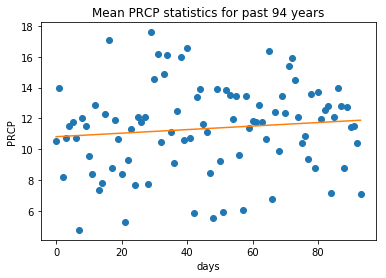

In [36]:
T_min = return_temp_data('PRCP')
plot_winter(T_min,'PRCP')

### Script for plotting yearly plots

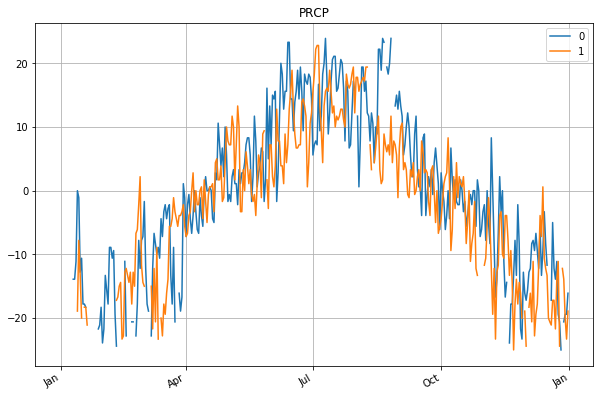

In [40]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [41]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

C:\Users\Sudarshan\Anaconda3\envs\py2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


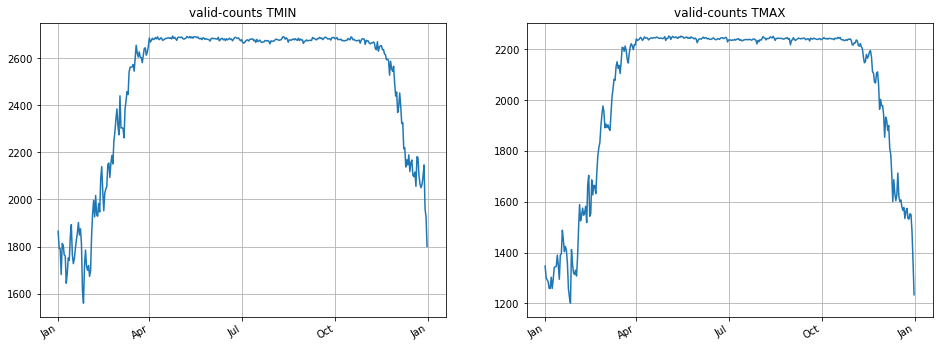

In [42]:
plot_pair(['TMIN','TMAX'],plot_valid)

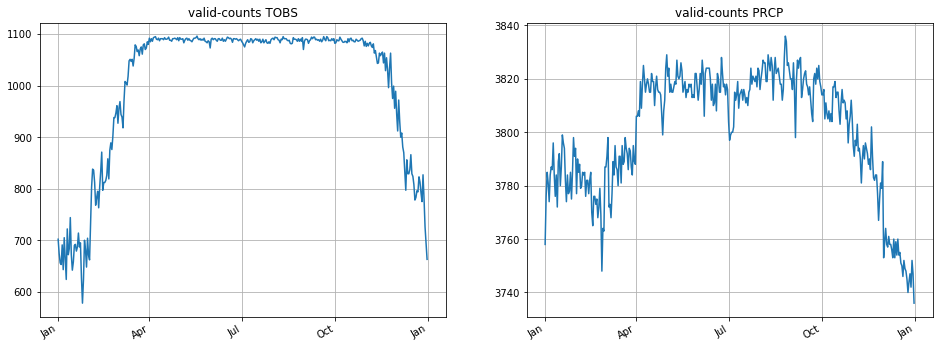

In [43]:
plot_pair(['TOBS','PRCP'],plot_valid)

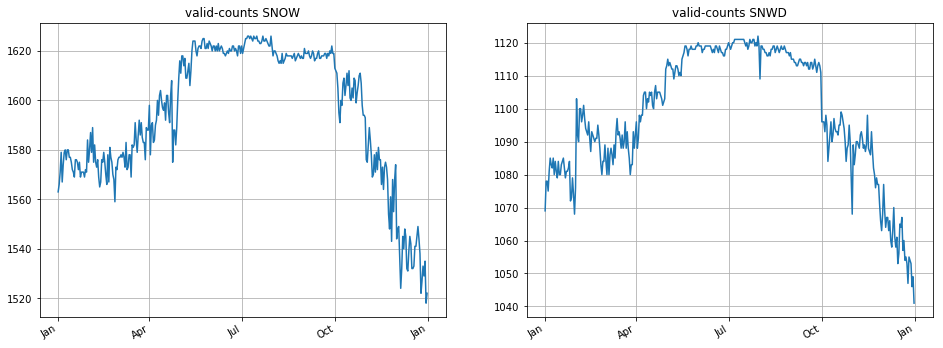

In [44]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [45]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    mean_list = []
    
    print np.mean(np.array(mean[:31]))
    print np.mean(np.array(mean[31:59]))
    print np.mean(np.array(mean[59:91]))
    print np.mean(np.array(mean[91:122]))
    print np.mean(np.array(mean[122:154]))
    print np.mean(np.array(mean[154:185]))
    print np.mean(np.array(mean[185:217]))
    print np.mean(np.array(mean[217:249]))
    print np.mean(np.array(mean[249:280]))
    print np.mean(np.array(mean[280:312]))
    print np.mean(np.array(mean[312:333]))
    print np.mean(np.array(mean[333:364]))
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std'+m)
    return mean_list

In [46]:
def get_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    mean_list = []
    
    mean_list.append(np.mean(np.array(mean[:31])))
    mean_list.append(np.mean(np.array(mean[31:59])))
    mean_list.append(np.mean(np.array(mean[59:91])))
    mean_list.append(np.mean(np.array(mean[91:122])))
    mean_list.append(np.mean(np.array(mean[122:154])))
    mean_list.append(np.mean(np.array(mean[154:185])))
    mean_list.append(np.mean(np.array(mean[185:217])))
    mean_list.append(np.mean(np.array(mean[217:249])))
    mean_list.append(np.mean(np.array(mean[249:280])))
    mean_list.append(np.mean(np.array(mean[280:312])))
    mean_list.append(np.mean(np.array(mean[312:333])))
    mean_list.append(np.mean(np.array(mean[333:364])))
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)
    return mean_list

In [58]:
T_max_mean = [-3.13064480935,-2.36767001073,1.59506457658,11.8155854265
,19.353705537
,23.8450845625
,27.2845657816
,25.6896435766
,18.5199469448
,19.443111119
,1.9529049077
-2.2731140628]

In [59]:
T_max_actual = [-6.2,-3.7,2.8,12.7,19.3,23.9,27.5,27.3,20.9,12.8,2.7,-4.7]

In [60]:
from scipy.stats import ks_2samp
A = np.array(T_max_mean)
B = np.array(T_max_actual)
test_stat = ks_2samp(A,B)

In [61]:
test_stat

Ks_2sampResult(statistic=0.25, pvalue=0.80673072782589772)

In [66]:
np.nanstd(A)

11.282182656336106

In [55]:
A.shape

(11L,)

-31.3064480935
-23.6767001073
15.9506457658
118.155854265
193.53705537
238.450845625
272.845657816
256.896435766
185.199469448
101.443111119
10.9529049077
-23.2731140628


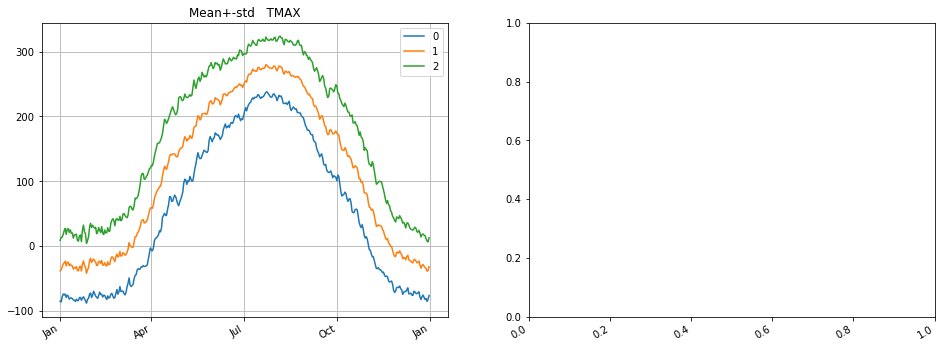

In [48]:
#plot_pair(['TMIN','TMAX'],plot_mean_std)
plot_pair(['TMAX'],plot_mean_std)

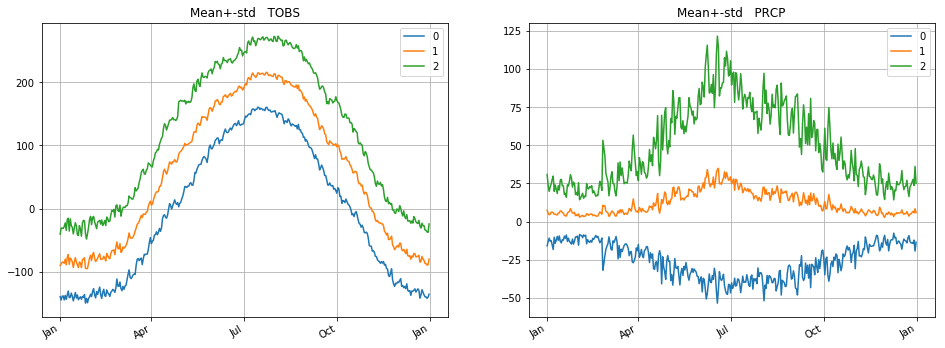

In [19]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

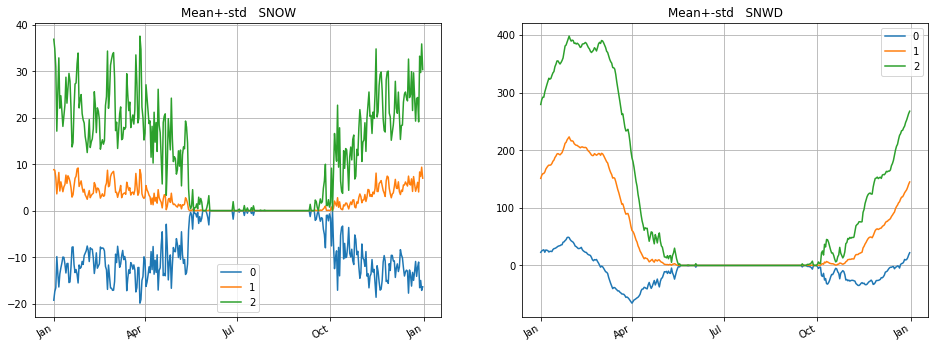

In [20]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [21]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

In [32]:
EV=STAT['TMIN']['eigvec']
min(EV[:,0])

-0.087825122865411609

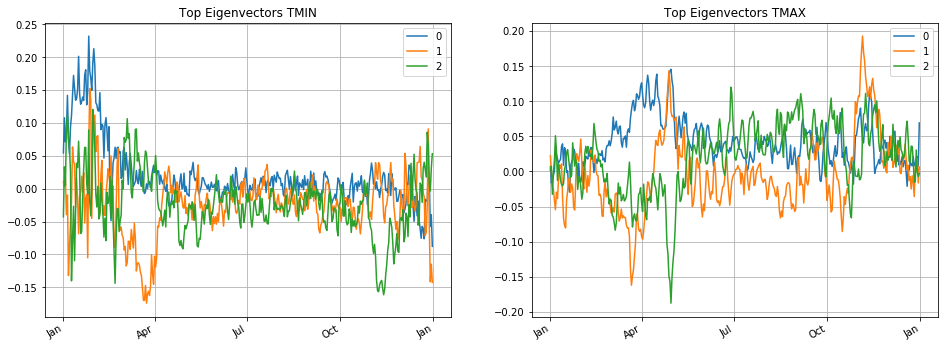

In [15]:
plot_pair(['TMIN','TMAX'],plot_eigen)

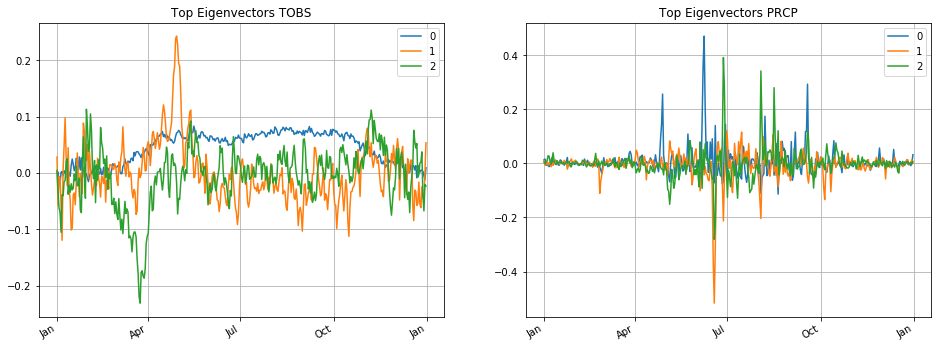

In [16]:
plot_pair(['TOBS','PRCP'],plot_eigen)

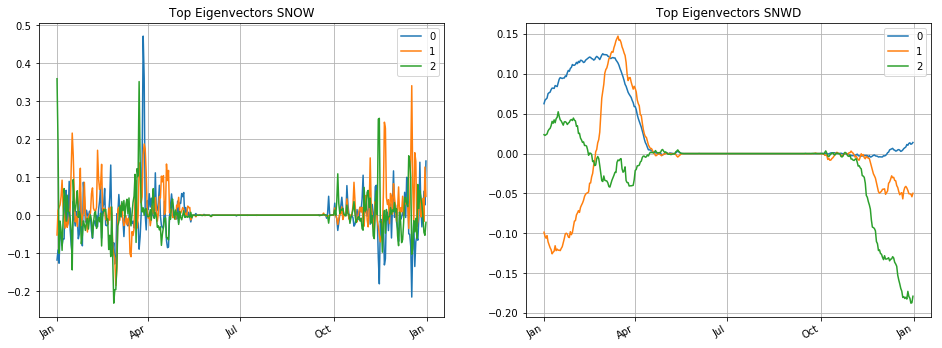

In [17]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [33]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

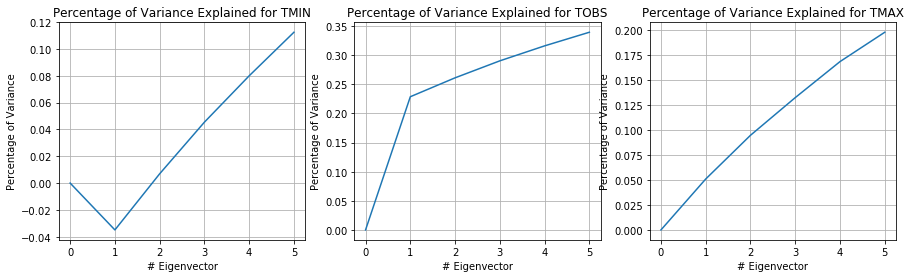

In [34]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

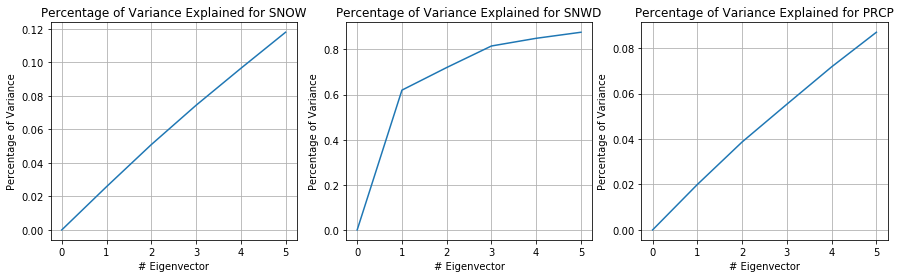

In [20]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [ ]:
#sc.stop()

In [47]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT latitude,longitude FROM weather"
print Query
df_lat_long = sqlContext.sql(Query)
print df_lat_long.count(),'rows'
df_lat_long.show(2)

SELECT latitude,longitude FROM weather
12673 rows
+--------+---------+
|latitude|longitude|
+--------+---------+
| 48.7603|-101.5089|
| 48.7603|-101.5089|
+--------+---------+
only showing top 2 rows



In [48]:
lat_long = df_lat_long.collect()

In [49]:
import gmplot

In [50]:
more_lats = [row[0] for row in lat_long]
more_lngs = [row[1] for row in lat_long]

In [57]:
gmap = gmplot.GoogleMapPlotter(more_lats[0],more_lngs[0],16)

In [58]:
gmap.scatter(more_lats, more_lngs,'k', marker=True)

In [59]:
gmap.draw("map.html")

In [61]:
import pickle

In [62]:

with open("test.txt", "wb") as fp:
    pickle.dump(lat_long, fp)

In [89]:
Query_mean = "SELECT *  FROM weather\n\tWHERE measurement='%s' and year='%s'"%('PRCP','2000')
print Query_mean
df_mean = sqlContext.sql(Query_mean)
print df_mean.count(),'rows'
df_mean.show(2)
#rows=df_T.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

SELECT * FROM weather
	WHERE measurement='PRCP' and year='2000'
49 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    482.0|    49.3|   -99.45|       PRCP|CA005010191|    12|[00 4D 00 00 00 4...|2000.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       PRCP|USC00326025|    14|[00 00 80 4A 80 4...|2000.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



In [91]:
data = df_mean.take(1)

In [69]:
m = 'SNWD'
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
print "Coefficient of variation for Mean distribution ",np.std(Mean) / np.mean(Mean)
print "Coefficient of variation for eig1 distribution ",np.std(STAT[m]['eigvec'][:,0]) / np.mean(STAT[m]['eigvec'][:,0])


Coefficient of variation for Mean distribution  1.35122505277
Coefficient of variation for eig1 distribution  1.68186742718
